In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git

%cd segment-anything-2

!pip install -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 510 (delta 142), reused 140 (delta 140), pack-reused 306 (from 1)
Receiving objects: 100% (510/510), 83.47 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd segment-anything-2/checkpoints/


/content/segment-anything-2/checkpoints


In [ ]:
!./download_ckpts.sh


--2024-09-25 03:05:08--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.84, 13.35.238.71, 13.35.238.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   163MB/s    in 0.9s    

2024-09-25 03:05:09 (163 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-09-25 03:05:09--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.84, 13.35.238.71, 13.35.238.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/vn

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
  torch.backends.cuda.matmul.allow_tf32 = True
  torch.backends.cudnn.allow_tf32 = True

In [ ]:
%cd /content/segment-anything-2/checkpoints/
from sam2.build_sam import build_sam2_video_predictor

checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

/content/segment-anything-2/checkpoints


/content/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
!ls

download_ckpts.sh	 sam2_hiera_large.pt  sam2_hiera_tiny.pt
sam2_hiera_base_plus.pt  sam2_hiera_small.pt


In [ ]:
%cd /content/segment-anything-2/

/content/segment-anything-2


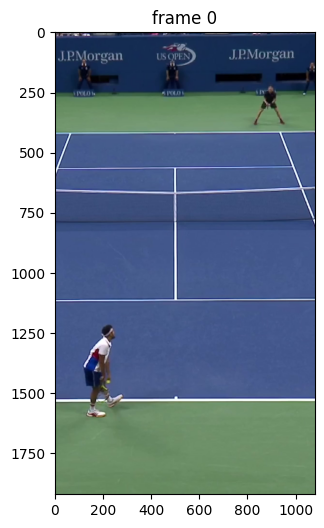

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./notebooks/videos/tennis"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 649/649 [00:50<00:00, 12.75it/s]


In [ ]:
predictor.reset_state(inference_state)

In [2]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[400, 1500]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

NameError: name 'np' is not defined